# GPU accelerated solution using NVIDIA RAPIDS cudf and cuml
# Data loading, preprocessing and feature engineering takes less than 3min in GPU.

In [1]:
import pandas
import numpy as np
import cudf as pd
import cupy as cp

import glob
import os
import gc
import time

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import GroupKFold
from scipy.optimize import minimize


import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib
from catboost import Pool, CatBoostRegressor
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import cuml
from cuml.neighbors import KNeighborsRegressor
from cuml import LinearRegression
from cuml import Ridge
from cuml.ensemble import RandomForestRegressor


path_submissions = '/'

target_name = 'target'
scores_folds = {}

def convert_to_32bit(df):
    for f in df.columns:
        if df[f].dtype == 'int64':
            df[f] = df[f].astype('int32')
        if df[f].dtype == 'float64':
            df[f] = df[f].astype('float32')
    return df

# Loading train and test sets

In [2]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')

train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)

train['is_train'] = 1
test['is_train'] = 0

train = convert_to_32bit(train)
test = convert_to_32bit(test)

print( train.shape )
print( test.shape )

(428932, 5)
(3, 4)


In [3]:
print(train.head(20))

    stock_id  time_id    target row_id  is_train
0          0        5  0.004136    0-5         1
1          0       11  0.001445   0-11         1
2          0       16  0.002168   0-16         1
3          0       31  0.002195   0-31         1
4          0       62  0.001747   0-62         1
5          0       72  0.004912   0-72         1
6          0       97  0.009388   0-97         1
7          0      103  0.004120  0-103         1
8          0      109  0.002182  0-109         1
9          0      123  0.002669  0-123         1
10         0      128  0.003702  0-128         1
11         0      146  0.005397  0-146         1
12         0      147  0.002751  0-147         1
13         0      152  0.003969  0-152         1
14         0      157  0.005525  0-157         1
15         0      159  0.002077  0-159         1
16         0      169  0.003365  0-169         1
17         0      207  0.007260  0-207         1
18         0      211  0.001707  0-211         1
19         0      21

In [4]:
print(test.head(20))

   stock_id  time_id row_id  is_train
0         0        4    0-4         0
1         0       32   0-32         0
2         0       34   0-34         0


# Checking how many stock_id there are in train and test

In [5]:
train_stock_ids = train['stock_id'].to_pandas().unique()
test_stock_ids = test['stock_id'].to_pandas().unique()
print( 'Sizes:', len(train_stock_ids), len(test_stock_ids) )
print( 'Train stocks:', train_stock_ids )
print( 'Test stocks:', test_stock_ids )

Sizes: 112 1
Train stocks: [  0   1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18
  19  20  21  22  23  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  46  47  48  50  51  52  53  55  56  58  59  60
  61  62  63  64  66  67  68  69  70  72  73  74  75  76  77  78  80  81
  82  83  84  85  86  87  88  89  90  93  94  95  96  97  98  99 100 101
 102 103 104 105 107 108 109 110 111 112 113 114 115 116 118 119 120 122
 123 124 125 126]
Test stocks: [0]


In [6]:
def transform(df, groupby='time_id', feat='price', agg='mean' ):
    return df.merge( 
        df.groupby(groupby)[feat].agg(agg).reset_index().rename({feat:feat+'_'+agg}, axis=1),
        on=groupby,
        how='left' 
    )

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df = convert_to_32bit(df)
    df = df.sort_values(['time_id','seconds_in_bucket']).reset_index(drop=True)
    
    # Calculate Wap
    df['wap1'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['wap2'] = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    df['wap3'] = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['wap4'] = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    
    
    # Calculate log returns
    df['log_return1'] = df['wap1'].log()
    df['log_return1'] = df['log_return1'] - df.groupby(['time_id'])['log_return1'].shift(1).reset_index(drop=True)

    df['log_return2'] = df['wap2'].log()
    df['log_return2'] = df['log_return2'] - df.groupby(['time_id'])['log_return2'].shift(1).reset_index(drop=True)

    df['log_return3'] = df['wap3'].log()
    df['log_return3'] = df['log_return3'] - df.groupby(['time_id'])['log_return3'].shift(1).reset_index(drop=True)

    df['log_return4'] = df['wap4'].log()
    df['log_return4'] = df['log_return4'] - df.groupby(['time_id'])['log_return4'].shift(1).reset_index(drop=True)
    
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    df['log_return1_sqr'] = df['log_return1'] ** 2
    df['log_return2_sqr'] = df['log_return2'] ** 2
    df['log_return3_sqr'] = df['log_return3'] ** 2
    df['log_return4_sqr'] = df['log_return4'] ** 2
    
    df = transform(df, groupby='time_id', feat='wap1', agg='median' )
    df = transform(df, groupby='time_id', feat='wap2', agg='median' )
    df = transform(df, groupby='time_id', feat='wap3', agg='median' )
    df = transform(df, groupby='time_id', feat='wap4', agg='median' )
    df = transform(df, groupby='time_id', feat='log_return1', agg='median' )
    df = transform(df, groupby='time_id', feat='log_return2', agg='median' )
    df = transform(df, groupby='time_id', feat='log_return3', agg='median' )
    df = transform(df, groupby='time_id', feat='log_return4', agg='median' )
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': ['sum', 'std', 'min','max'],
        'wap2': ['sum', 'std', 'min','max'],
        'wap3': ['sum', 'std', 'min','max'],
        'wap4': ['sum', 'std', 'min','max'],
        'log_return1_sqr': ['sum', 'std', 'min','max'],
        'log_return2_sqr': ['sum', 'std', 'min','max'],
        'log_return3_sqr': ['sum', 'std', 'min','max'],
        'log_return4_sqr': ['sum', 'std', 'min','max'],
        'wap_balance': ['sum', 'mean', 'min','max'],
        'price_spread':['sum', 'mean', 'min','max'],
        'price_spread2':['sum', 'mean', 'min','max'],
        'bid_spread':['sum', 'mean', 'min','max'],
        'ask_spread':['sum', 'mean', 'min','max'],
        'total_volume':['sum', 'mean', 'min','max'],
        'volume_imbalance':['sum', 'mean', 'min','max'],
        "bid_ask_spread":['sum',  'mean', 'min','max'],
        
        "wap1_median":['sum',  'mean', 'min','max'],
        "wap2_median":['sum',  'mean', 'min','max'],
        "wap3_median":['sum',  'mean', 'min','max'],
        "wap4_median":['sum',  'mean', 'min','max'],
        "log_return1_median":['mean',  'std', 'min','max'],
        "log_return2_median":['mean',  'std', 'min','max'],
        "log_return3_median":['mean',  'std', 'min','max'],
        "log_return4_median":['mean',  'std', 'min','max'],
    }
    create_feature_dict_time = {
        'log_return1_sqr': ['sum', 'std', 'min','max'],
        'log_return2_sqr': ['sum', 'std', 'min','max'],
        'log_return3_sqr': ['sum', 'std', 'min','max'],
        'log_return4_sqr': ['sum', 'std', 'min','max'],
    }
    
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        if add_suffix:
            df_feature.columns = [col + '_' + str(seconds_in_bucket) for col in df_feature.columns]
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    
    # Drop tmp columns
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['stock_id'] = str(stock_id) + '-'

    df_feature['row_id'] = df_feature['stock_id'] + df_feature['time_id_'].astype(str)
    
    return df_feature

In [7]:
%%time

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df = convert_to_32bit(df)
    df = df.sort_values('time_id').reset_index(drop=True)

    df['log_return'] = df['price'].log()
    df['log_return'] = df['log_return'] - df.groupby(['time_id'])['log_return'].shift(1).reset_index(drop=True)
    df['log_return_sqr'] = df['log_return'] ** 2
    
    df['amount']=df['price']*df['size']
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return_sqr': ['sum', 'std','max', 'min'],
        'seconds_in_bucket':['nunique','std', 'mean','max', 'min'],
        'size':['sum', 'nunique','std','max', 'min'],
        'order_count':['sum','nunique','max','min','std'],
        'amount':['sum','std','max','min'],
    }
    create_feature_dict_time = {
        'log_return_sqr': ['sum', 'std','max','min'],
        'seconds_in_bucket':['nunique'],
        'size':['sum','mean','std','min','max'],
        'order_count':['sum','mean','std','min','max'],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature.columns = [col + '_' + str(seconds_in_bucket) for col in df_feature.columns]
        return df_feature

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_250 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 250, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    df = df.sort_values(['time_id','seconds_in_bucket']).reset_index(drop=True)
    
    df = transform(df, groupby='time_id', feat='price', agg='mean' )
    df = transform(df, groupby='time_id', feat='price', agg='sum' )
    df = transform(df, groupby='time_id', feat='size', agg='mean' )
    df['price_dif'] = ((df['price'] - df.groupby(['time_id'])['price'].shift(1).reset_index(drop=True)) / df['price']).fillna(0.)
    df['tendencyV'] = df['size'] * df['price_dif']
    df['f_max'] = 1 * (df['price'] >= df['price_mean'])
    df['f_min'] = 1 * (df['price'] < df['price_mean'])
    df['df_max'] = 1 * (df['price_dif'] >= 0)
    df['df_min'] = 1 * (df['price_dif'] < 0)
    df['abs_dif'] = (df['price'] - df['price_mean']).abs()
    df['price_sqr'] = df['price']**2
    df['size_dif'] = (df['size'] - df['size_mean']).abs()
    df['size_sqr'] = df['size']**2
    df['iqr_p25'] = df.groupby(['time_id'])['price'].quantile(0.15).reset_index(drop=True)
    df['iqr_p75'] = df.groupby(['time_id'])['price'].quantile(0.85).reset_index(drop=True)
    df['iqr_p_v25'] = df.groupby(['time_id'])['size'].quantile(0.15).reset_index(drop=True)
    df['iqr_p_v75'] = df.groupby(['time_id'])['size'].quantile(0.85).reset_index(drop=True)

    df = transform(df, groupby='time_id', feat='price_dif', agg='std' )
    df = transform(df, groupby='time_id', feat='tendencyV', agg='std' )
    df = transform(df, groupby='time_id', feat='f_max', agg='std' )
    df = transform(df, groupby='time_id', feat='f_min', agg='std' )
    df = transform(df, groupby='time_id', feat='df_max', agg='std' )
    df = transform(df, groupby='time_id', feat='df_min', agg='std' )
    df = transform(df, groupby='time_id', feat='size_dif', agg='std' )
    
    dt = df.groupby('time_id')[['tendencyV','price','price_dif','f_max','f_min','df_max','df_min','abs_dif','price_sqr','size_dif','size_sqr','iqr_p25','iqr_p75','iqr_p_v25','iqr_p_v75','price_dif_std','tendencyV_std','f_max_std','f_min_std','df_max_std','df_min_std','size_dif_std']].agg(
        {
            'tendencyV':['sum','std','max', 'min'],
            'price':['mean','std','max', 'min'],
            'price_dif':['mean','std','max', 'min'],
            'f_max':['mean','std','max', 'min'],
            'f_min':['mean','std','max', 'min'],
            'df_max':['mean','std','max', 'min'],
            'df_min':['mean','std','max', 'min'],
            'abs_dif':['median','std','max', 'min'],
            'price_sqr':['sum','std','max', 'min'],
            'size_dif':['median','std','max', 'min'],
            'size_sqr':['sum','std','max', 'min'],
            'iqr_p25':['mean','std','max', 'min'],
            'iqr_p75':['mean','std','max', 'min'],
            'iqr_p_v25':['mean','std','max', 'min'],
            'iqr_p_v75':['mean','std','max', 'min'],
            'price_dif_std':['mean','std','max', 'min'],
            'tendencyV_std':['mean','std','max', 'min'],
            'f_max_std':['mean','std','max', 'min'],
            'f_min_std':['mean','std','max', 'min'],
            'df_max_std':['mean','std','max', 'min'],
            'df_min_std':['mean','std','max', 'min'],
            'size_dif_std':['mean','std','max', 'min'],
        }
    )
    dt.columns = [i+'_'+j for i, j in dt.columns] 
    df_feature = df_feature.merge(dt, left_on='time_id_', right_index=True, how='left')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_250, how = 'left', left_on = 'time_id_', right_on = 'time_id__250')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    
    # Drop tmp columns
    df_feature = df_feature.sort_values(['time_id_' ]).reset_index(drop=True)
    
    stock_id = file_path.split('=')[1]
    df_feature['stock_id'] = str(stock_id) + '-'
    df_feature['row_id'] = df_feature['stock_id'] + df_feature['time_id_'].astype(str)
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__250', 'time_id__200', 'time_id_','time_id__100','stock_id'], axis = 1, inplace = True)

    fnames = ['trade_' + f for f in df_feature.columns]
    fnames[-1] = 'row_id'
    df_feature.columns = fnames

    return df_feature

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


# Process all train .parquet files. Create features using cudf (GPU)
# Note cudf speed to load and apply all feature engineering in all train set stocks.

In [8]:
%%time
DF_TRAIN = []
for stock_id in tqdm(train_stock_ids, disable=True):
    df_tmp = pd.merge( 
        book_preprocessor(data_dir + "book_train.parquet/stock_id=" + str(stock_id)),
        trade_preprocessor(data_dir + "trade_train.parquet/stock_id=" + str(stock_id)),
        on = 'row_id',
        how = 'left'
    )
    df_tmp['stock_id'] = stock_id
    df_tmp = convert_to_32bit(df_tmp) # to save memory
    #df_tmp.to_parquet( 'train_parquet/'+str(stock_id)+'.parquet' )
    DF_TRAIN.append(df_tmp)

# Concatenate all stock_id in the same dataframe
DF_TRAIN = pd.concat(DF_TRAIN, ignore_index=True )
_ = gc.collect()

# Flag to filter train/test rows
DF_TRAIN['is_test'] = 0
DF_TRAIN.shape

CPU times: user 2min 23s, sys: 54.6 s, total: 3min 18s
Wall time: 4min 2s


(428932, 381)

# Process all test .parquet files. Create features using cudf (GPU)

In [9]:
%%time
DF_TEST = []
for stock_id in tqdm(test_stock_ids, disable=True):
    df_tmp = pd.merge( 
        book_preprocessor(data_dir + "book_test.parquet/stock_id=" + str(stock_id)),
        trade_preprocessor(data_dir + "trade_test.parquet/stock_id=" + str(stock_id)),
        on = 'row_id',
        how = 'left'
    )
    df_tmp['stock_id'] = stock_id
    df_tmp = convert_to_32bit(df_tmp) # to save memory
    #df_tmp.to_parquet( 'test_parquet/'+str(stock_id)+'.parquet' )
    DF_TEST.append(df_tmp)
    
# Concatenate all stock_id in the same dataframe
DF_TEST = pd.concat(DF_TEST, ignore_index=True )
_ = gc.collect()

# Flag to filter train/test rows
DF_TEST['is_test'] = 1
DF_TEST.shape

CPU times: user 975 ms, sys: 6.31 ms, total: 981 ms
Wall time: 1 s


(1, 381)

In [10]:
TRAIN = pd.concat( [DF_TRAIN, DF_TEST] ).sort_values(['stock_id','time_id_']).reset_index(drop=True)

del DF_TRAIN, DF_TEST
_ = gc.collect()
TRAIN.shape

(428933, 381)

In [11]:
%%time

def get_time_stock(df_):
    vol_cols = ['log_return1_sqr_sum_500', 'log_return2_sqr_sum_500', 'log_return3_sqr_sum_500', 'log_return4_sqr_sum_500', 'trade_log_return_sqr_sum', 'trade_log_return_sqr_std', 'trade_seconds_in_bucket_nunique' ]

    df = df_.copy()
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    df_stock_id.columns = ['_'.join(col) + '_stock' for col in df_stock_id.columns]

    df_time_id = df.groupby(['time_id_'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    df_time_id.columns = ['_'.join(col)+ '_time' for col in df_time_id.columns]
    
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id_'], right_on = ['time_id___time'])
    df.drop(['stock_id__stock', 'time_id___time'], axis = 1, inplace = True)
    return df

TRAIN_ = get_time_stock(TRAIN)
TRAIN_.drop(['stock_id','time_id_'], axis = 1, inplace = True)
print(TRAIN_.shape)
print(TRAIN_.head())

(428933, 435)
     wap1_sum  wap1_std  wap1_min  wap1_max    wap2_sum  wap2_std  wap2_min  \
0  586.394531  0.001048  1.000232  1.005272  586.406311  0.001073  1.000342   
1  383.670380  0.000625  1.000389  1.003103  383.669189  0.000647  1.000368   
2  329.755890  0.000367  0.998489  1.000047  329.717987  0.000392  0.998222   
3  520.670532  0.000625  0.997884  1.000688  520.688599  0.000645  0.997807   
4  458.869781  0.000455  0.998788  1.000538  458.851654  0.000510  0.998716   

   wap2_max    wap3_sum  wap3_std  ...  trade_log_return_sqr_sum_max_time  \
0  1.005439  586.390137  0.001056  ...                           0.000056   
1  1.003249  383.680878  0.000610  ...                           0.000011   
2  1.000098  329.738678  0.000347  ...                           0.000020   
3  1.000808  520.681396  0.000629  ...                           0.000034   
4  1.000650  458.860962  0.000411  ...                           0.000010   

   trade_log_return_sqr_sum_min_time  trade_log_

In [12]:
train = train.merge(TRAIN_, on='row_id', how='left' )
test  = test.merge(TRAIN_, on='row_id', how='left' )

del TRAIN_, TRAIN
_ = gc.collect()

train.shape, test.shape

((428932, 439), (3, 438))

In [13]:
train.head()

,stock_id,time_id,target,row_id,is_train,wap1_sum,wap1_std,wap1_min,wap1_max,wap2_sum,...,trade_log_return_sqr_sum_max_time,trade_log_return_sqr_sum_min_time,trade_log_return_sqr_std_mean_time,trade_log_return_sqr_std_std_time,trade_log_return_sqr_std_max_time,trade_log_return_sqr_std_min_time,trade_seconds_in_bucket_nunique_mean_time,trade_seconds_in_bucket_nunique_std_time,trade_seconds_in_bucket_nunique_max_time,trade_seconds_in_bucket_nunique_min_time
0,4,5609,0.002764,4-5609,1,234.228592,0.000473,1.000143,1.001917,234.240967,...,0.000012,6.641111e-07,9.841943e-08,9.412308e-08,5.000384e-07,5.469094e-09,63.928571,52.715062,339,10
1,4,5729,0.004137,4-5729,1,147.972504,0.000882,0.997198,1.001449,147.921539,...,0.000040,2.405270e-07,3.256500e-07,3.560842e-07,1.855957e-06,5.656652e-09,78.544643,81.789103,410,4
2,4,5667,0.005416,4-5667,1,211.811005,0.000974,0.997434,1.000918,211.822830,...,0.000031,1.217248e-06,1.847355e-07,2.900721e-07,2.544010e-06,5.169157e-09,90.678571,72.919333,431,14
3,4,5787,0.011738,4-5787,1,233.334702,0.003693,0.990884,1.006155,233.417175,...,0.000713,2.319537e-05,4.934117e-06,7.598185e-06,6.821076e-05,6.057900e-08,121.401786,123.753712,597,10
4,4,5611,0.004903,4-5611,1,374.548096,0.000677,1.000044,1.002860,374.592072,...,0.000068,2.982078e-06,2.190114e-07,2.283604e-07,1.652506e-06,1.621297e-08,103.482143,81.994175,507,16


# Now time to calculate correlation between all stock. The best way is using a correlation matrix, so first pivot all target variables by stock_id, then just calculate the correlation matrix.
# To Find correlated stocks use Kmeans algorithm on the correlation matrix. This procedure is a bit leak because it not being processed using crossvalidation, but it won't leak much since only 6 clusters are being calculated.

In [14]:
%%time
train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns=['stock_id'], values=['target']).fillna(0.)
corr = train_p.corr()

km = cuml.KMeans(n_clusters=6, max_iter=2000, n_init=5).fit(corr)
df = pd.DataFrame( {'stock_id': [ f[1] for f in corr.columns ], 'cluster': km.labels_} )
df = convert_to_32bit(df)

train = train.merge(df, on='stock_id', how='left')
test = test.merge(df, on='stock_id', how='left')


del train_p, df, corr, km
_ = gc.collect()

# Clusters found
train.groupby('cluster')['time_id'].agg('count')

CPU times: user 3.67 s, sys: 146 ms, total: 3.82 s
Wall time: 4.41 s


cluster
5     34455
3    126389
0    122559
2     99580
4     34469
1     11480
Name: time_id, dtype: int32

In [15]:
matTrain = []
matTest = []

# 6 clusters
for ind in range(train.cluster.max()+1):
    print(ind)
    newDf = train.loc[train['cluster']==ind].copy()
    newDf = newDf.groupby(['time_id']).agg('mean')
    newDf.loc[:,'stock_id'] = 127+ind
    matTrain.append ( newDf )
    
    newDf = test.loc[test['cluster']==ind].copy()
    newDf = newDf.groupby(['time_id']).agg('mean')
    newDf.loc[:,'stock_id'] = 127+ind
    matTest.append ( newDf )
    
matTrain = pd.concat(matTrain).reset_index()
matTrain.drop(columns=['target'],inplace=True)

matTest = pd.concat(matTest).reset_index()

matTrain.shape, matTest.shape

0
1
2
3
4
5


((22980, 438), (3, 438))

In [16]:
matTest = pd.concat([matTest , matTrain.loc[matTrain.time_id==5]])
matTrain = matTrain.pivot(index='time_id', columns='stock_id')
matTrain.columns = [x[0]+'_stock'+str(int(x[1])) for x in matTrain.columns]
matTrain.reset_index(inplace=True)

matTest = matTest.pivot(index='time_id', columns='stock_id')
matTest.columns = [x[0]+'_stock'+str(int(x[1])) for x in matTest.columns]
matTest.reset_index(inplace=True)

matTrain.shape, matTest.shape

((3830, 2617), (4, 2617))

In [17]:
kfeatures = [
    'time_id',
        
    'wap1_sum_stock127',
    'wap1_sum_stock128',     
    'wap1_sum_stock129',
    'wap1_sum_stock130',     
    'wap1_sum_stock131',
    'wap1_sum_stock132',
        
    'wap2_sum_stock127',
    'wap2_sum_stock128',     
    'wap2_sum_stock129',
    'wap2_sum_stock130',     
    'wap2_sum_stock131',
    'wap2_sum_stock132',
        
    'wap3_sum_stock127',
    'wap3_sum_stock128',     
    'wap3_sum_stock129',
    'wap3_sum_stock130',     
    'wap3_sum_stock131',
    'wap3_sum_stock132',
        
    'wap4_sum_stock127',
    'wap4_sum_stock128',     
    'wap4_sum_stock129',
    'wap4_sum_stock130',     
    'wap4_sum_stock131',
    'wap4_sum_stock132',
    
    'log_return1_sqr_sum_stock127',
    'log_return1_sqr_sum_stock128',     
    'log_return1_sqr_sum_stock129',
    'log_return1_sqr_sum_stock130',     
    'log_return1_sqr_sum_stock131',
    'log_return1_sqr_sum_stock132',

    'log_return2_sqr_sum_stock127',
    'log_return2_sqr_sum_stock128',     
    'log_return2_sqr_sum_stock129',
    'log_return2_sqr_sum_stock130',     
    'log_return2_sqr_sum_stock131',
    'log_return2_sqr_sum_stock132',

    'log_return3_sqr_sum_stock127',
    'log_return3_sqr_sum_stock128',     
    'log_return3_sqr_sum_stock129',
    'log_return3_sqr_sum_stock130',     
    'log_return3_sqr_sum_stock131',
    'log_return3_sqr_sum_stock132',

    'log_return4_sqr_sum_stock127',
    'log_return4_sqr_sum_stock128',     
    'log_return4_sqr_sum_stock129',
    'log_return4_sqr_sum_stock130',     
    'log_return4_sqr_sum_stock131',
    'log_return4_sqr_sum_stock132',
    
    'total_volume_sum_stock127',
    'total_volume_sum_stock128', 
    'total_volume_sum_stock129',
    'total_volume_sum_stock130', 
    'total_volume_sum_stock131',
    'total_volume_sum_stock132',
    
    'trade_size_sum_stock127',
    'trade_size_sum_stock128', 
    'trade_size_sum_stock129',
    'trade_size_sum_stock130', 
    'trade_size_sum_stock131',
    'trade_size_sum_stock132',
    
    'trade_order_count_sum_stock127',
    'trade_order_count_sum_stock128',
    'trade_order_count_sum_stock129',
    'trade_order_count_sum_stock130',
    'trade_order_count_sum_stock131',      
    'trade_order_count_sum_stock132',
    
    'price_spread_sum_stock127',
    'price_spread_sum_stock128',
    'price_spread_sum_stock129',
    'price_spread_sum_stock130',
    'price_spread_sum_stock131',   
    'price_spread_sum_stock132',
    
    'bid_spread_sum_stock127',
    'bid_spread_sum_stock128',
    'bid_spread_sum_stock129',
    'bid_spread_sum_stock130',
    'bid_spread_sum_stock131',
    'bid_spread_sum_stock132',
    
    'ask_spread_sum_stock127',
    'ask_spread_sum_stock128',
    'ask_spread_sum_stock129',
    'ask_spread_sum_stock130',
    'ask_spread_sum_stock131',   
    'ask_spread_sum_stock132',
    
    'volume_imbalance_sum_stock127',
    'volume_imbalance_sum_stock128',
    'volume_imbalance_sum_stock129',
    'volume_imbalance_sum_stock130',
    'volume_imbalance_sum_stock131',       
    'volume_imbalance_sum_stock132',
    
    'bid_ask_spread_sum_stock127',
    'bid_ask_spread_sum_stock128',
    'bid_ask_spread_sum_stock129',
    'bid_ask_spread_sum_stock130',
    'bid_ask_spread_sum_stock131',
    'bid_ask_spread_sum_stock132',
]
matTrain = convert_to_32bit(matTrain)
matTest = convert_to_32bit(matTest)

train = pd.merge(train,matTrain[kfeatures],how='left',on='time_id')
test = pd.merge(test,matTest[kfeatures],how='left',on='time_id')
_ = gc.collect()

print(train.shape, test.shape)

(428932, 536) (3, 535)


In [18]:
# train=train[~(train["stock_id"]==31)].reset_index(drop=True)
# _= gc.collect()

train = convert_to_32bit(train)
test  = convert_to_32bit(test)
_= gc.collect()

train.shape, test.shape

((428932, 536), (3, 535))

In [19]:
y_target = train.target.to_pandas() #need to be numpy or pandas for sklearn 
time_id = train.time_id.to_pandas()
NFOLD = 5

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


# Target min and max values
np.min(y_target), np.max(y_target)

(0.00010526300320634618, 0.07032062113285065)

# XGBoost GPU

In [20]:
xgbtime = time.time()

# Define the custom metric to optimize
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    err = rmspe(labels, preds)
    return 'rmspe', err

def train_and_evaluate_xgb(train, test, params, colNames):
    # Sample weight
    train['target_sqr'] = 1. / (train['target'] ** 1.60 + 9e-7)    
    train.loc[train.stock_id==31,'target_sqr'] = 0.0001

    dtest = xgb.DMatrix(test[colNames])

    y_train = np.zeros(len(train))
    y_test = np.zeros(len(test))

    kf = GroupKFold(n_splits=NFOLD)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train, y_target, time_id)):
        print('Fold:', fold)
        dtrain = xgb.DMatrix(train.loc[train_idx, colNames], train.loc[train_idx, 'target']*10000, weight=train.loc[train_idx, 'target_sqr'])
        dvalid = xgb.DMatrix(train.loc[valid_idx, colNames], train.loc[valid_idx, 'target']*10000)
        model = xgb.train(
            params,
            dtrain,
            3000,
            #[(dtrain, "train"), (dvalid, "valid")],
            [(dvalid, "valid")],
            verbose_eval=250,
            early_stopping_rounds=50,
            feval=evalerror,
        )
        y_train[valid_idx] = np.clip(model.predict(dvalid)/10000, 2e-4, 0.072)
        y_test += np.clip((model.predict(dtest))/10000, 2e-4, 0.072)
        print( 'Rmspe Fold:', rmspe(y_target[valid_idx], y_train[valid_idx]) )
    y_test /= NFOLD
    
    print( 'XGBoost Rmspe CV:', rmspe(y_target, y_train) )
    print( pandas.DataFrame.from_dict( model.get_score(), orient='index').sort_values(0, ascending=False).head(20) )
    print()
    
    del model, dtest, dtrain, dvalid
    _ = gc.collect()
    
    return y_train, y_test


colNames = [col for col in list(train.columns) if col not in {'is_train', 'time_id', 'target', 'row_id', 'target_sqr', 'is_train'}]
colNames = [col for col in colNames if col.find('min')<0 ]
params = {
        "subsample": 0.60,
        "colsample_bytree": 0.40,
        "max_depth": 6,
        "learning_rate": 0.02,
        "objective": "reg:squarederror",
        'disable_default_eval_metric': 1, # <- necessary for XGBoost to earlystop by Rmspe and not the default rmse
        "nthread": -1,
        "tree_method": "gpu_hist",
        "gpu_id": 0,
        "max_bin": 128, 
        'min_child_weight': 0,
        'reg_lambda': 0.001,
        'reg_alpha': 0.001, 
        'seed' : 2021,
        'single_precision_histogram': False,
    }
y_train1a, y_test1a = train_and_evaluate_xgb(train, test, params, colNames)


colNames = [col for col in list(train.columns) if col not in {'is_train', 'time_id', 'target', 'row_id', 'target_sqr', 'is_train'}]
colNames = [col for col in colNames if col.find('max')<0 ]
params = {
        "subsample": 0.85,
        "colsample_bytree": 0.25,
        "max_depth": 7,
        "learning_rate": 0.02,
        "objective": "reg:squarederror",
        'disable_default_eval_metric': 1, # <- necessary for XGBoost to earlystop by Rmspe and not the default rmse
        "nthread": -1,
        "tree_method": "gpu_hist",
        "gpu_id": 0,
        "max_bin": 128, 
        'min_child_weight': 0,
        'reg_lambda': 0.001,
        'reg_alpha': 0.001, 
        'seed' : 2022,
        'single_precision_histogram': False,
    }
y_train1b, y_test1b = train_and_evaluate_xgb(train, test, params, colNames)


y_train1 = 0.5*y_train1a + 0.5*y_train1b
y_test1  = 0.5*y_test1a  + 0.5*y_test1b
_= gc.collect()
xgbtime = time.time() - xgbtime

print( 'XGBoost Rmspe CV:', rmspe(y_target, y_train1), 'time: ', int(xgbtime), 's', y_test1[:3] )

Fold: 0
[0]	valid-rmspe:0.96212
[250]	valid-rmspe:0.24624
[258]	valid-rmspe:0.24672
Rmspe Fold: 0.23589238209511823
Fold: 1
[0]	valid-rmspe:0.96177
[250]	valid-rmspe:0.25110
[276]	valid-rmspe:0.25080
Rmspe Fold: 0.2508031012809249
Fold: 2
[0]	valid-rmspe:0.96171
[250]	valid-rmspe:0.22787
[322]	valid-rmspe:0.22790
Rmspe Fold: 0.2278440571142703
Fold: 3
[0]	valid-rmspe:0.96168
[250]	valid-rmspe:0.23743
[255]	valid-rmspe:0.23759
Rmspe Fold: 0.2375764647952687
Fold: 4
[0]	valid-rmspe:0.96207
[245]	valid-rmspe:0.22770
Rmspe Fold: 0.2276991079355103
XGBoost Rmspe CV: 0.23611432334183377
                                       0
trade_log_return_sqr_sum_mean_stock  555
log_return1_sqr_sum_500_mean_stock   536
wap1_sum_stock127                    438
log_return1_sqr_sum                  361
ask_spread_max                       296
wap1_sum_stock130                    277
trade_order_count_sum_stock127       272
trade_log_return_sqr_std_mean_time   262
total_volume_sum_stock131            255
tr

# CatBoost

In [21]:
catbtime = time.time()

def train_and_evaluate_catb(train, test, params):

    # Sample weight
    train['target_sqr'] = 1. / (train['target'] ** 1.75 + 1e-6)
    train.loc[train.stock_id==31,'target_sqr'] = 1.

    colNames = [col for col in list(train.columns) if col not in {'is_train', 'time_id', 'target', 'row_id', 'target_sqr', 'is_train'}]

    y_train = np.zeros(len(train))
    y_test = np.zeros(len(test))

    kf = GroupKFold(n_splits=NFOLD)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train, y_target, time_id)):
        print('Fold:', fold)

        model = CatBoostRegressor(
            iterations=3000,
            learning_rate=0.05,
            depth=7,
            loss_function='RMSE',
            #l2_leaf_reg = 0.001,
            #random_strength = 0.5,
            #bagging_temperature = 1.0,
            task_type="GPU",
            random_seed = 2021,
        )        
        model.fit(
            X=train.loc[train_idx, colNames].to_pandas(), y=train.loc[train_idx, 'target'].to_pandas(),
            sample_weight = train.loc[train_idx, 'target_sqr'].to_pandas(),
            eval_set = (train.loc[valid_idx, colNames].to_pandas(), train.loc[valid_idx, 'target'].to_pandas(),),
            early_stopping_rounds = 20,
            cat_features = [0],
            verbose=False)

        y_train[valid_idx] = np.clip(model.predict(train.loc[valid_idx, colNames].to_pandas()), 2e-4, 0.072)
        y_test += np.clip((model.predict(test[colNames].to_pandas())), 2e-4, 0.072)
        print( 'Catboost Rmspe Fold:', rmspe(y_target[valid_idx], y_train[valid_idx]) )        
        print()
    y_test /= NFOLD
    return y_train, y_test


y_train2, y_test2 = train_and_evaluate_catb(train, test, params)
_= gc.collect()
catbtime = time.time() - catbtime
     
print( 'Catboost Rmspe CV:', rmspe(y_target, y_train2), 'time: ', int(catbtime), 's', y_test2[:3]  )

Fold: 0
Catboost Rmspe Fold: 0.23267178268632976

Fold: 1
Catboost Rmspe Fold: 0.25631776043806753

Fold: 2
Catboost Rmspe Fold: 0.23585117053487398

Fold: 3
Catboost Rmspe Fold: 0.2424829556894706

Fold: 4
Catboost Rmspe Fold: 0.229466408482937

Catboost Rmspe CV: 0.23954690686122715 time:  396 s [0.00151681 0.00174524 0.00174524]


# LightGBM GPU

Fold: 0
Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 0.000506325	training's RMSPE: 0.216926	valid_1's rmse: 0.001388	valid_1's RMSPE: 0.223851
[200]	training's rmse: 0.000481708	training's RMSPE: 0.204035	valid_1's rmse: 0.00133637	valid_1's RMSPE: 0.219486
[300]	training's rmse: 0.000467211	training's RMSPE: 0.196608	valid_1's rmse: 0.00131156	valid_1's RMSPE: 0.218228
[400]	training's rmse: 0.000457107	training's RMSPE: 0.191743	valid_1's rmse: 0.00129493	valid_1's RMSPE: 0.217685
Early stopping, best iteration is:
[392]	training's rmse: 0.000457992	training's RMSPE: 0.192122	valid_1's rmse: 0.00129474	valid_1's RMSPE: 0.217616
Fold: 1
Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 0.000504846	training's RMSPE: 0.214089	valid_1's rmse: 0.00134627	valid_1's RMSPE: 0.239334
[200]	training's rmse: 0.000480459	training's RMSPE: 0.201611	valid_1's rmse: 0.00130206	valid_1's RMSPE: 0.232865
[300]	training's rmse: 0

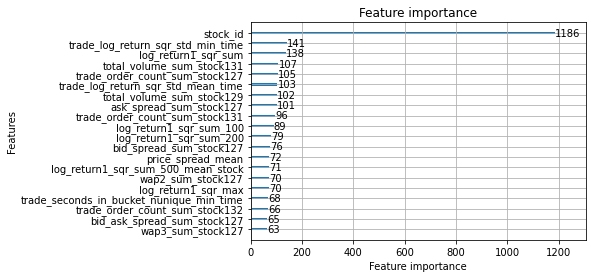

In [22]:
lgbtime = time.time()

# Define the custom metric to optimize
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    
    features = [col for col in train.columns if col not in {"time_id", "target", "target_sqr", "row_id", 'is_train'}]
    y = train['target']
    
    y_train = np.zeros(train.shape[0])
    y_test = np.zeros(test.shape[0])
    
    kf = GroupKFold(n_splits=NFOLD)
    for fold, (trn_ind, val_ind) in enumerate(kf.split(train, y_target, time_id)):
        print('Fold:', fold)
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_tra, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        train_dataset = lgb.Dataset(x_train[features], y_tra, weight = (1. / (np.square(y_tra) + 1e-6)) )
        valid_dataset = lgb.Dataset(x_val[features], y_val)
        model = lgb.train(params = params,
                          num_boost_round=3000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, valid_dataset], 
                          verbose_eval = 100,
                          early_stopping_rounds=20,
                          feval = feval_rmspe)
        
        y_train[val_ind] = np.clip(model.predict(x_val[features]), 2e-4, 0.072)
        y_test += np.clip((model.predict(test[features])), 2e-4, 0.072)        
    y_test/=NFOLD
    
    print('LightGBM Rmspe Fold:', rmspe(y_target, y_train))
    lgb.plot_importance(model,max_num_features=20)
    
    return y_train, y_test


params = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':255,
    'min_data_in_leaf':750,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 3,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':2021,
    'n_jobs':-1,
    'verbose': -1,
    'device': 'gpu',
    'num_gpu': 1,
    'gpu_platform_id':-1,
    'gpu_device_id':-1,
    'gpu_use_dp': False,
}

train_pandas = train.to_pandas()
test_pandas = test.to_pandas()

y_train3, y_test3 = train_and_evaluate_lgb(train_pandas, test_pandas, params)
_= gc.collect()

print( 'LightGBM Rmspe CV:', rmspe(y_target, y_train3), 'time: ', int(time.time() - lgbtime), 's', y_test3[:3]   )

# Neuron Network

## Release GPU for NN

In [23]:
del train,test
_= gc.collect()

## Common methods for NN

In [24]:
#reset Keras Session
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

## Baseline

In [25]:
from sklearn.preprocessing import MinMaxScaler
from numpy.random import seed
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
import numpy as nptensorflow
from tensorflow.keras import backend as K
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

nn_base_time = time.time()

def root_mean_squared_per_error(y_true, y_pred):
#     tf.print('y_true', y_true)
#     tf.print('y_pred', y_pred)
    return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))

def base_model(max_id_num, feature_num, stock_embedding_size, hidden_units, dropout_rates):
    print('base_model', max_id_num, feature_num, stock_embedding_size, hidden_units, dropout_rates)
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(feature_num,), name='num_data')


    #embedding, flatenning and concatenating
    stock_embedded = keras.layers.Embedding(max_id_num+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
#     # Add one or more hidden layers
    for i in range(len(hidden_units)):
        out = keras.layers.Dense(hidden_units[i], activation='swish')(out)
#         out = keras.layers.Dropout(dropout_rates[i])(out)
        

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model

def train_and_evaluate_nn_base(train, test, params):
    
    features = [col for col in train.columns if col not in {"time_id", "target", "target_sqr", "row_id", 'is_train'}]
    y = train['target']
    
    y_train = np.zeros(train.shape[0])
    y_test = np.zeros(test.shape[0])
    
    print('Check null in train', train[features].isnull().sum())
    print('Check null in test', test[features].isnull().sum())
    train[features] = train[features].fillna(train[features].mean())
    test[features] = test[features].fillna(train[features].mean())
    print('Check null in test again', test[features].isnull().sum())
    
    kf = GroupKFold(n_splits=NFOLD)
    for fold, (trn_ind, val_ind) in enumerate(kf.split(train, y_target, time_id)):
        print('Fold:', fold)
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_tra, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        cat_data = x_train['stock_id']
        features.remove('stock_id')

        scaler = MinMaxScaler(feature_range=(-1, 1))
        num_data = x_train[features]
        num_data = scaler.fit_transform(num_data.values)
        cat_data_val = x_val['stock_id']
        num_data_val = x_val[features]
        num_data_val = scaler.transform(num_data_val.values)
        
        model = base_model(max(cat_data), len(features), params['stock_embedding_size'], params['hidden_units'], params['dropout_rates'])

        model.compile(
            keras.optimizers.Adam(learning_rate=params['learning_rate']),
            loss=root_mean_squared_per_error
        )
        
#         

        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=20, verbose=0,
            mode='min',restore_best_weights=True)

        plateau = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.2, patience=7, verbose=0,
            mode='min')

        model.fit([cat_data, num_data], 
                  y_tra,               
#                   batch_size=2048,
#                   epochs=1000,
                  batch_size=params['batch_size'],
                  epochs=params['epochs'],
                  validation_data=([cat_data_val, num_data_val], y_val),
                  callbacks=[es, 
#                              plateau
                            ],
                  validation_batch_size=len(y_val),
                  shuffle=True,
                 verbose = 1)

        y_train[val_ind] = np.clip(model.predict([cat_data_val, num_data_val]).reshape(1,-1)[0], 2e-4, 0.072)
        test_nn =scaler.transform(test[features].values)
        y_test += np.clip(model.predict([test['stock_id'], test_nn]).reshape(1,-1)[0], 2e-4, 0.072)
        features.append('stock_id')
        
        print(y_train[val_ind][:3], y_test[:3])
        
        #Delete model and release GPU memory
        del model, cat_data, num_data, cat_data_val, num_data_val, scaler
        reset_keras()
        gc.collect()
    y_test/=NFOLD
    
    print('NN base Rmspe Fold:', rmspe(y_target, y_train))
    
    return y_train, y_test

params = {
    'batch_size': 2048,
    'epochs': 1000,
    'learning_rate': 0.006,
    'stock_embedding_size': 24,
    'hidden_units': [128, 128, 64, 32],
    'dropout_rates': [0.2, 0.4, 0.99, 0.99]
}

y_nn_train1, y_nn_test1 = train_and_evaluate_nn_base(train_pandas, test_pandas, params)
_= gc.collect()

print( 'NN base Rmspe CV:', rmspe(y_target, y_nn_train1), 'time: ', int(time.time() - nn_base_time), 's', y_nn_test1[:3])

2021-09-23 03:35:04.150679: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7958173208606509428
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14015859264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16151535074730329626
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


2021-09-23 03:35:07.827754: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-23 03:35:07.831190: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-23 03:35:07.833773: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-23 03:35:07.838407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 03:35:07.839374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla 

Check null in train stock_id                       0
wap1_sum                       0
wap1_std                       0
wap1_min                       0
wap1_max                       0
                              ..
bid_ask_spread_sum_stock128    0
bid_ask_spread_sum_stock129    0
bid_ask_spread_sum_stock130    0
bid_ask_spread_sum_stock131    0
bid_ask_spread_sum_stock132    0
Length: 532, dtype: int64
Check null in test stock_id                       0
wap1_sum                       2
wap1_std                       2
wap1_min                       2
wap1_max                       2
                              ..
bid_ask_spread_sum_stock128    3
bid_ask_spread_sum_stock129    3
bid_ask_spread_sum_stock130    2
bid_ask_spread_sum_stock131    3
bid_ask_spread_sum_stock132    3
Length: 532, dtype: int64
Check null in test again stock_id                       0
wap1_sum                       0
wap1_std                       0
wap1_min                       0
wap1_max                  

2021-09-23 03:35:14.965003: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-23 03:35:14.965426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 03:35:14.966055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-23 03:35:14.966253: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-23 03:35:14.966301: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-23 03:35:14.966325: I tensorflow/stream_executor/platform/

Epoch 1/1000
 20/168 [==>...........................] - ETA: 0s - loss: 488.4590

2021-09-23 03:35:17.304342: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-23 03:35:17.306309: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


166/168 [============================>.] - ETA: 0s - loss: 152.6685

2021-09-23 03:35:19.169378: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 182211588 exceeds 10% of free system memory.


168/168 [==============================] - 3s 13ms/step - loss: 150.8412 - val_loss: 8.9513
Epoch 2/1000
 10/168 [>.............................] - ETA: 0s - loss: 6.1179

2021-09-23 03:35:19.426450: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 182211588 exceeds 10% of free system memory.


168/168 [==============================] - 1s 7ms/step - loss: 4.9048 - val_loss: 3.5141
Epoch 3/1000
  1/168 [..............................] - ETA: 0s - loss: 3.5250

2021-09-23 03:35:20.565622: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 182211588 exceeds 10% of free system memory.


168/168 [==============================] - 1s 7ms/step - loss: 4.3061 - val_loss: 2.0464
Epoch 4/1000
  1/168 [..............................] - ETA: 0s - loss: 2.0990

2021-09-23 03:35:21.674444: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 182211588 exceeds 10% of free system memory.


168/168 [==============================] - 1s 7ms/step - loss: 1.7077 - val_loss: 1.7949
Epoch 5/1000
168/168 [==============================] - 1s 7ms/step - loss: 1.5512 - val_loss: 1.6354
Epoch 6/1000
168/168 [==============================] - 1s 6ms/step - loss: 1.4296 - val_loss: 0.7649
Epoch 7/1000
168/168 [==============================] - 1s 7ms/step - loss: 1.9169 - val_loss: 1.5850
Epoch 8/1000
168/168 [==============================] - 1s 7ms/step - loss: 1.4068 - val_loss: 2.1839
Epoch 9/1000
168/168 [==============================] - 1s 7ms/step - loss: 1.4857 - val_loss: 15.4595
Epoch 10/1000
168/168 [==============================] - 1s 7ms/step - loss: 6.1468 - val_loss: 0.5907
Epoch 11/1000
168/168 [==============================] - 2s 10ms/step - loss: 1.0467 - val_loss: 1.2796
Epoch 12/1000
168/168 [==============================] - 1s 7ms/step - loss: 2.4599 - val_loss: 2.5238
Epoch 13/1000
168/168 [==============================] - 1s 7ms/step - loss: 1.9753 - val_

2021-09-23 03:35:56.443234: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-23 03:35:56.443816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 03:35:56.444562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-23 03:35:56.445103: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-23 03:35:56.445445: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-23 03:35:56.445744: I tensorflow/stream_executor/platform/

Fold: 1
base_model 126 531 24 [128, 128, 64, 32] [0.2, 0.4, 0.99, 0.99]
Epoch 1/1000
168/168 [==============================] - 3s 13ms/step - loss: 161.5261 - val_loss: 0.5200
Epoch 2/1000
168/168 [==============================] - 1s 7ms/step - loss: 0.4476 - val_loss: 0.3694
Epoch 3/1000
168/168 [==============================] - 1s 7ms/step - loss: 0.4642 - val_loss: 0.4222
Epoch 4/1000
168/168 [==============================] - 1s 7ms/step - loss: 0.3781 - val_loss: 0.4747
Epoch 5/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.8217 - val_loss: 0.8346
Epoch 6/1000
168/168 [==============================] - 1s 7ms/step - loss: 0.5050 - val_loss: 0.8932
Epoch 7/1000
168/168 [==============================] - 1s 7ms/step - loss: 0.5832 - val_loss: 0.8754
Epoch 8/1000
168/168 [==============================] - 1s 7ms/step - loss: 0.3194 - val_loss: 0.8654
Epoch 9/1000
168/168 [==============================] - 1s 7ms/step - loss: 0.3230 - val_loss: 0.8352
Epoch 1

2021-09-23 03:36:42.112785: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-23 03:36:42.113444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 03:36:42.114262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-23 03:36:42.114533: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-23 03:36:42.114675: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-23 03:36:42.114760: I tensorflow/stream_executor/platform/

Fold: 2
base_model 126 531 24 [128, 128, 64, 32] [0.2, 0.4, 0.99, 0.99]
Epoch 1/1000
168/168 [==============================] - 2s 9ms/step - loss: 120.7391 - val_loss: 10.1332
Epoch 2/1000
168/168 [==============================] - 1s 7ms/step - loss: 5.2754 - val_loss: 5.8674
Epoch 3/1000
168/168 [==============================] - 1s 7ms/step - loss: 2.2130 - val_loss: 5.9020
Epoch 4/1000
168/168 [==============================] - 1s 7ms/step - loss: 2.2032 - val_loss: 7.8368
Epoch 5/1000
168/168 [==============================] - 1s 7ms/step - loss: 1.7653 - val_loss: 7.8057
Epoch 6/1000
168/168 [==============================] - 1s 7ms/step - loss: 1.5862 - val_loss: 7.7928
Epoch 7/1000
168/168 [==============================] - 1s 7ms/step - loss: 1.4135 - val_loss: 7.6742
Epoch 8/1000
168/168 [==============================] - 1s 7ms/step - loss: 1.5359 - val_loss: 9.6058
Epoch 9/1000
168/168 [==============================] - 1s 7ms/step - loss: 2.6920 - val_loss: 10.5639
Epoch 

2021-09-23 03:37:16.775287: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-23 03:37:16.775878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 03:37:16.776404: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-23 03:37:16.776627: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-23 03:37:16.776726: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-23 03:37:16.776780: I tensorflow/stream_executor/platform/

Fold: 3
base_model 126 531 24 [128, 128, 64, 32] [0.2, 0.4, 0.99, 0.99]
Epoch 1/1000
168/168 [==============================] - 2s 9ms/step - loss: 186.6547 - val_loss: 6.0952
Epoch 2/1000
168/168 [==============================] - 1s 7ms/step - loss: 9.7033 - val_loss: 3.9375
Epoch 3/1000
168/168 [==============================] - 1s 7ms/step - loss: 4.8309 - val_loss: 4.5228
Epoch 4/1000
168/168 [==============================] - 1s 7ms/step - loss: 5.1819 - val_loss: 4.0058
Epoch 5/1000
168/168 [==============================] - 1s 7ms/step - loss: 3.1266 - val_loss: 2.9289
Epoch 6/1000
168/168 [==============================] - 1s 7ms/step - loss: 2.6850 - val_loss: 2.6660
Epoch 7/1000
168/168 [==============================] - 1s 7ms/step - loss: 2.3566 - val_loss: 2.4621
Epoch 8/1000
168/168 [==============================] - 1s 8ms/step - loss: 2.2190 - val_loss: 2.3207
Epoch 9/1000
168/168 [==============================] - 1s 7ms/step - loss: 2.1557 - val_loss: 2.2738
Epoch 10

2021-09-23 03:38:34.727197: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-23 03:38:34.727553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 03:38:34.728213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-23 03:38:34.728569: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-23 03:38:34.728780: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-23 03:38:34.728882: I tensorflow/stream_executor/platform/

Fold: 4
base_model 126 531 24 [128, 128, 64, 32] [0.2, 0.4, 0.99, 0.99]
Epoch 1/1000
168/168 [==============================] - 2s 10ms/step - loss: 76.4649 - val_loss: 5.7488
Epoch 2/1000
168/168 [==============================] - 1s 7ms/step - loss: 2.9332 - val_loss: 0.5913
Epoch 3/1000
168/168 [==============================] - 1s 6ms/step - loss: 1.4646 - val_loss: 0.8482
Epoch 4/1000
168/168 [==============================] - 1s 7ms/step - loss: 1.9301 - val_loss: 1.1468
Epoch 5/1000
168/168 [==============================] - 1s 7ms/step - loss: 3.9191 - val_loss: 0.4113
Epoch 6/1000
168/168 [==============================] - 1s 7ms/step - loss: 0.3735 - val_loss: 0.3177
Epoch 7/1000
168/168 [==============================] - 2s 9ms/step - loss: 0.3304 - val_loss: 0.2971
Epoch 8/1000
168/168 [==============================] - 1s 7ms/step - loss: 0.3095 - val_loss: 0.2888
Epoch 9/1000
168/168 [==============================] - 1s 7ms/step - loss: 0.3019 - val_loss: 0.3827
Epoch 10

2021-09-23 03:39:59.634619: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-23 03:39:59.635301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 03:39:59.636012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-23 03:39:59.636342: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-23 03:39:59.636503: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-23 03:39:59.636620: I tensorflow/stream_executor/platform/

NN base Rmspe Fold: 1.180226882297499
NN base Rmspe CV: 1.180226882297499 time:  290 s [0.01456    0.00353242 0.00353242]


# Ensembling Time

In [26]:
print( 'LightGBM Rmspe:', rmspe(y_target, y_train3) )
print( 'XGBoost Rmspe:', rmspe(y_target, y_train1) )
print( 'CatBoost Rmspe:', rmspe(y_target, y_train2) )
print( 'NN base Rmspe:', rmspe(y_target, y_nn_train1) )

LightGBM Rmspe: 0.21903828259599362
XGBoost Rmspe: 0.26405645266421324
CatBoost Rmspe: 0.23954690686122715
NN base Rmspe: 1.180226882297499


In [27]:
ENSEMBLING_SIZE = 4

In [28]:
def minimize_arit(W):
    ypred = W[0] * y_train1 + W[1] * y_train2 + W[2] * y_train3 + W[3] * y_nn_train1
    return rmspe(y_target, ypred )

W0 = minimize(minimize_arit, [1./ENSEMBLING_SIZE]*ENSEMBLING_SIZE, options={'gtol': 1e-6, 'disp': True}).x
print('Weights arit:',W0)

Optimization terminated successfully.
         Current function value: 0.216253
         Iterations: 20
         Function evaluations: 110
         Gradient evaluations: 22
Weights arit: [-0.03443753 -0.25966713  1.27195819 -0.00388321]


In [29]:
def signed_power(var, p=2):
    return np.sign(var) * np.abs(var)**p

def minimize_geom(W):
    ypred = signed_power(y_train1, W[0]) * signed_power(y_train2, W[1]) * signed_power(y_train3, W[2]) * signed_power(y_nn_train1, W[3])
    return rmspe(y_target, ypred)

W1 = minimize(minimize_geom, [1./ENSEMBLING_SIZE]*ENSEMBLING_SIZE, options={'gtol': 1e-6, 'disp': True}).x

print('weights geom:',W1)

Optimization terminated successfully.
         Current function value: 0.216592
         Iterations: 26
         Function evaluations: 150
         Gradient evaluations: 30
weights geom: [-0.15528512 -0.14165227  1.29906935  0.00324779]


In [30]:
ypred0 = W0[0] * y_train1 + W0[1] * y_train2 + W0[2] * y_train3 + W0[3] * y_nn_train1
print( np.min(ypred0), np.max(ypred0))

ypred1 = signed_power(y_train1, W1[0]) * signed_power(y_train2, W1[1]) * signed_power(y_train3, W1[2]) * signed_power(y_nn_train1, W1[3])
print( np.min(ypred1) , np.max(ypred1) )

print( 'Ensemble:', rmspe(y_target, np.clip((ypred0+ypred1)/2 ,0.0002, 0.071) ) )

-0.0005220599516617341 0.01938902127511775
0.00036401996953145624 0.01996012280109064
Ensemble: 0.2163415302796934


In [31]:
print( np.min(ypred0),np.mean(ypred0),np.max(ypred0),np.std(ypred0) )
print( np.min(ypred1),np.mean(ypred1),np.max(ypred1),np.std(ypred1) )

-0.0005220599516617341 0.0035032202452474123 0.01938902127511775 0.0023657187563743774
0.00036401996953145624 0.0035037045342169175 0.01996012280109064 0.0023810719376274846


(array([4.9800e+02, 2.0260e+03, 5.1640e+03, 1.1171e+04, 1.6949e+04,
        2.0945e+04, 2.4099e+04, 2.6132e+04, 2.6012e+04, 2.4862e+04,
        2.4229e+04, 2.1788e+04, 1.9906e+04, 1.8231e+04, 1.6937e+04,
        1.5480e+04, 1.3929e+04, 1.2383e+04, 1.1220e+04, 1.0170e+04,
        9.1900e+03, 8.2720e+03, 7.5340e+03, 6.7000e+03, 6.2380e+03,
        5.4480e+03, 4.9740e+03, 4.5980e+03, 4.1120e+03, 3.7200e+03,
        3.3780e+03, 3.0690e+03, 2.8780e+03, 2.6130e+03, 2.4270e+03,
        2.2440e+03, 2.0620e+03, 1.8830e+03, 1.7510e+03, 1.5820e+03,
        1.5000e+03, 1.3400e+03, 1.2830e+03, 1.1780e+03, 1.0720e+03,
        1.0550e+03, 9.5000e+02, 8.9800e+02, 8.4800e+02, 7.3800e+02,
        7.4200e+02, 7.0300e+02, 6.4500e+02, 6.0600e+02, 5.7000e+02,
        5.4600e+02, 4.6300e+02, 4.7200e+02, 4.3400e+02, 4.2400e+02,
        3.9400e+02, 3.4000e+02, 3.4800e+02, 3.5500e+02, 3.3000e+02,
        2.9400e+02, 2.8100e+02, 2.7400e+02, 2.5500e+02, 2.3000e+02,
        2.1000e+02, 2.1300e+02, 2.0000e+02, 1.80

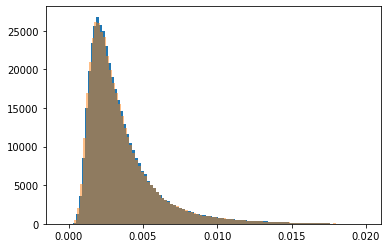

In [32]:
plt.hist(ypred0, bins=100)
plt.hist(ypred1, bins=100, alpha=0.5)

In [33]:
train_pandas['ypred'] = np.clip((ypred0+ypred1)/2,0.0002, 0.071)
train_pandas['error'] = (train_pandas['target'] - train_pandas['ypred']) / train_pandas['target']
train_pandas['error'] = train_pandas['error']**2

dt = train_pandas.groupby('stock_id')['error'].agg('mean').reset_index()
dt['error'] = np.sqrt(dt['error'])
dt = dt.sort_values('error', ascending=False)
dt.to_csv('error-contribution.csv', index=False)
del train_pandas['ypred'], train_pandas['error']
dt.head(10)

,stock_id,error
28,31,0.559558
34,37,0.293036
17,18,0.284870
30,33,0.279234
78,88,0.273201
53,60,0.271555
97,110,0.266315
24,27,0.262541
71,81,0.260154
70,80,0.258400


In [34]:
dt.tail(10)

,stock_id,error
68,77,0.171416
54,61,0.171126
32,35,0.170161
10,10,0.169922
45,50,0.169229
74,84,0.168716
13,14,0.164393
84,96,0.163891
109,124,0.163878
50,56,0.156132


In [35]:
ypred0 = W0[0] * y_test1 + W0[1] * y_test2 + W0[2] * y_test3 + W0[3] * y_nn_test1
ypred1 = signed_power(y_test1, W1[0]) * signed_power(y_test2, W1[1]) * signed_power(y_test3, W1[2]) * signed_power(y_nn_test1, W1[3])

ypredtest = np.clip((ypred0+ypred1)/2,0.0002, 0.071)
print( ypred0[:3],  ypred1[:3], ypredtest[:3] )

test_pandas['target'] = ypredtest
test_pandas[['row_id', 'target']].to_csv('submission.csv',index = False)
test_pandas[['row_id', 'target']].head(3)

[ 0.00041291 -0.00132578 -0.00132578] [0.00055841 0.0005168  0.0005168 ] [0.00048566 0.0002     0.0002    ]


,row_id,target
0,0-4,0.000486
1,0-32,0.000200
2,0-34,0.000200
